# imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets seqeval
!pip install pyyaml
!pip install sentencepiece
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.4 

In [ ]:
import json
from datasets import load_dataset
from PIL import Image
import transformers
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D, load_metric
from transformers import LayoutLMv2Model, LayoutLMv2Config, LayoutLMv2Processor, LayoutXLMTokenizer
from transformers import LayoutXLMProcessor, AutoProcessor
import numpy as np
from transformers import LayoutLMv2ForTokenClassification, AdamW, TrainingArguments, Trainer,AutoTokenizer
import torch
from tqdm.notebook import tqdm
import pandas as pd

from transformers import LayoutLMv3ForTokenClassification

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
%load_ext tensorboard

# Load Data

In [ ]:
PATH = '/content/drive/MyDrive/we/data_IB/'

In [ ]:
TRAIN_PATH = PATH + 'train.json'
VAL_PATH = PATH + 'validation.json'
TEST_PATH = PATH + 'test.json'

In [ ]:
features = Features({
    'id': Value(dtype='int64', id=None),
    'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
    'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
    'ner_tags': Sequence(feature=ClassLabel(
        num_classes=11,
        names=['NONE',
 'B-WE_JOB_TITLE',
 'I-WE_JOB_TITLE',
 'B-WE_DATE',
 'I-WE_DATE',
 'B-WE_LOC',
 'I-WE_LOC',
 'B-WE_ORG',
 'I-WE_ORG',
 'B-WE_DESCRIPTION',
 'I-WE_DESCRIPTION']
        , id=None), 
        length=-1, id=None),
    'image': Value(dtype='string', id=None),
    })

In [ ]:
train_val_dataset = load_dataset('json', data_files={'train':TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH},field="cvs",features=features)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-7c046e5aa0de7f2a/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_val_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 64
    })
    val: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 14
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 14
    })
})

In [ ]:
labels = train_val_dataset['train'].features['ner_tags'].feature.names
labels

['NONE',
 'B-WE_JOB_TITLE',
 'I-WE_JOB_TITLE',
 'B-WE_DATE',
 'I-WE_DATE',
 'B-WE_LOC',
 'I-WE_LOC',
 'B-WE_ORG',
 'I-WE_ORG',
 'B-WE_DESCRIPTION',
 'I-WE_DESCRIPTION']

In [ ]:
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'NONE': 0,
 'B-WE_JOB_TITLE': 1,
 'I-WE_JOB_TITLE': 2,
 'B-WE_DATE': 3,
 'I-WE_DATE': 4,
 'B-WE_LOC': 5,
 'I-WE_LOC': 6,
 'B-WE_ORG': 7,
 'I-WE_ORG': 8,
 'B-WE_DESCRIPTION': 9,
 'I-WE_DESCRIPTION': 10}

# Process Data

In [ ]:
from datasets.features import ClassLabel

features = train_val_dataset["train"].features
column_names = train_val_dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(train_val_dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [ ]:
"""
tokenizer = LayoutXLMTokenizer.from_pretrained('microsoft/layoutxlm-base')
processor = LayoutXLMProcessor.from_pretrained('microsoft/layoutxlm-base', apply_ocr = False)
"""
tokenizer = AutoTokenizer.from_pretrained('microsoft/layoutlmv2-base-uncased')
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv2-base-uncased", apply_ocr=False)

#processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [ ]:
def prepare_examples(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image']]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images,
                             words,
                             boxes=boxes,
                             word_labels=word_labels,
                             max_length=384,
                             stride=128,
                             return_overflowing_tokens=True,
                             return_offsets_mapping=True,
                             padding="max_length",
                             truncation=True)

  sample_mapping = encoding.pop("overflow_to_sample_mapping")

  offset_mapping = encoding.pop("offset_mapping")

  return encoding

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
"""
# XML
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(384, 4)),
    'labels': Sequence(ClassLabel(names=labels)),
})

"""
# v2
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(384, 4)),
    'labels': Sequence(ClassLabel(names=label_list)),
})

"""
# V3
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})
"""


train_dataset = train_val_dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
val_dataset = train_val_dataset["val"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
test_dataset = train_val_dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
    num_rows: 79
})

In [ ]:
train_dataset.features

{'image': Array3D(shape=(3, 224, 224), dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(384, 4), dtype='int64', id=None),
 'labels': Sequence(feature=ClassLabel(names=['NONE', 'B-WE_JOB_TITLE', 'I-WE_JOB_TITLE', 'B-WE_DATE', 'I-WE_DATE', 'B-WE_LOC', 'I-WE_LOC', 'B-WE_ORG', 'I-WE_ORG', 'B-WE_DESCRIPTION', 'I-WE_DESCRIPTION'], id=None), length=-1, id=None)}

In [ ]:
train_dataset.set_format(type="torch", device=device)
val_dataset.set_format(type="torch", device=device)
test_dataset.set_format(type="torch", device=device)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

# Load Model

In [ ]:
model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutxlm-base',
                                                          num_labels=len(labels))
"""
model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                          num_labels=num_labels)
"""
model.to(device)

Some weights of the model checkpoint at microsoft/layoutxlm-base were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.22.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.12.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv3.norm.num_batches_tracked

LayoutLMv2ForTokenClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
# Set id2label and label2id 
model.config.id2label = id2label
model.config.label2id = label2id

# Train

In [ ]:
from torch.utils.tensorboard import SummaryWriter
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [ ]:
import torch.nn as nn
import os
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fct = nn.CrossEntropyLoss()
global_step = 0
num_train_epochs = 20
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

metric = load_metric("seqeval")
return_entity_level_metrics = True

min_valid_loss = np.inf

counter = 0
patience_counter = 0

for epoch in range(num_train_epochs):
  running_loss = 0
  correct=0
  total=0
  print("Epoch:", epoch)
  for batch in tqdm(train_dataloader):
    #put the model in training mode
    model.train() 
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(**batch) 

    predictions = outputs.logits.argmax(dim=2)

    true_predictions = [
      [id2label[p.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions,batch['labels'])
      ]
    true_labels = [
      [id2label[l.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions,  batch['labels'])
      ]
    metric.add_batch(predictions=true_predictions, references=true_labels)
    labels = batch['labels']
    logits = outputs.get("logits")
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    writer.add_scalar("Loss/train", loss, epoch)
        
    # print loss every 100 steps
    if global_step % 100 == 0:
      print(f"Loss after {global_step} steps: {loss.item()}")
      final_score = metric.compute(predictions=true_predictions, references=true_labels)
      print(final_score)
      writer.add_scalar("overall_precision/train", final_score["overall_precision"], epoch)
      writer.add_scalar("overall_recall/train", final_score["overall_recall"], epoch)
      writer.add_scalar("overall_f1/train", final_score["overall_f1"], epoch)
      writer.add_scalar("overall_accuracy/train", final_score["overall_accuracy"], epoch)

    loss.backward()
    optimizer.step()

    # Incrementing loss
    running_loss += loss.item()

    global_step += 1

  valid_loss = 0.0
  model.eval()
  for batch in tqdm(val_dataloader, desc="Evaluating"):
    with torch.no_grad():
      # forward pass
      outputs = model(**batch) 
      
      labels = batch['labels']
      logits = outputs.get("logits")
      loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
      writer.add_scalar("Loss/val", loss, epoch)
      # Incrementing loss
      valid_loss += loss.item()
    
  # Averaging out loss over entire batch
  running_loss /= len(train_dataloader)
  valid_loss /= len(val_dataloader)

  print('Training loss: {} \t\t Validation Loss: {}'.format(running_loss, valid_loss))
  # predictions
  predictions = outputs.logits.argmax(dim=2)

  # Remove ignored index (special tokens)
  true_predictions = [
      [id2label[p.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, batch['labels'])
  ]
  true_labels = [
      [id2label[l.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, batch['labels'])
  ]

  metric.add_batch(predictions=true_predictions, references=true_labels)

  final_score = metric.compute(predictions=true_predictions, references=true_labels)
  print(final_score)
  writer.add_scalar("overall_precision/val", final_score["overall_precision"], epoch)
  writer.add_scalar("overall_recall/val", final_score["overall_recall"], epoch)
  writer.add_scalar("overall_f1/val", final_score["overall_f1"], epoch)
  writer.add_scalar("overall_accuracy/val", final_score["overall_accuracy"], epoch)

  if min_valid_loss > valid_loss :
    print(f'Validation Loss Decreased({min_valid_loss:^.6f}--->{valid_loss:^.6f})')
    min_valid_loss = valid_loss        

  accu = 0
  if final_score['overall_accuracy'] > accu:
      accu = final_score['overall_accuracy']
      name_model = f"/content/modelLMv2/model-{accu:.3f}"
      
      model.save_pretrained(name_model)
      torch.save(model.state_dict(), "/content/drive/MyDrive/modelLMv2.pt")
  else:
        patience_counter += 1
        if patience_counter >= 3:
            print(f'Validation Loss did not improve for {patience_counter} epochs. Stopping training.')
            break

# Test

In [ ]:
train_state = {}

In [ ]:
running_loss = 0.
running_acc = 0.
metric = load_metric("seqeval")
for batch_index, batch in enumerate(tqdm(test_dataloader)):
  outputs = model(**batch) 
  labels = batch['labels']
  logits = outputs.get("logits")
  loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
  loss_batch = loss.item()
  running_loss += (loss_batch - running_loss) / (batch_index + 1)
  writer.add_scalar("Loss/test", loss, batch_index)

  predictions = outputs.logits.argmax(dim=2)
  # Remove ignored index (special tokens)
  true_predictions = [
      [id2label[p.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, batch['labels'])
  ]
  true_labels = [
      [id2label[l.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, batch['labels'])
  ]
  final_score = metric.compute(predictions=true_predictions, references=true_labels)
  acc_batch = final_score["overall_accuracy"]
  running_acc += (acc_batch - running_acc) / (batch_index + 1)
  writer.add_scalar("overall_precision/test", final_score["overall_precision"], batch_index)
  writer.add_scalar("overall_recall/test", final_score["overall_recall"], batch_index)
  writer.add_scalar("overall_f1/test", final_score["overall_f1"], batch_index)
  writer.add_scalar("overall_accuracy/test", final_score["overall_accuracy"], batch_index)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.247
Test Accuracy: 0.96


# Tests in Real Example

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/sections/modelXML-087.pt", map_location=torch.device('cpu')))

FileNotFoundError: ignored

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])


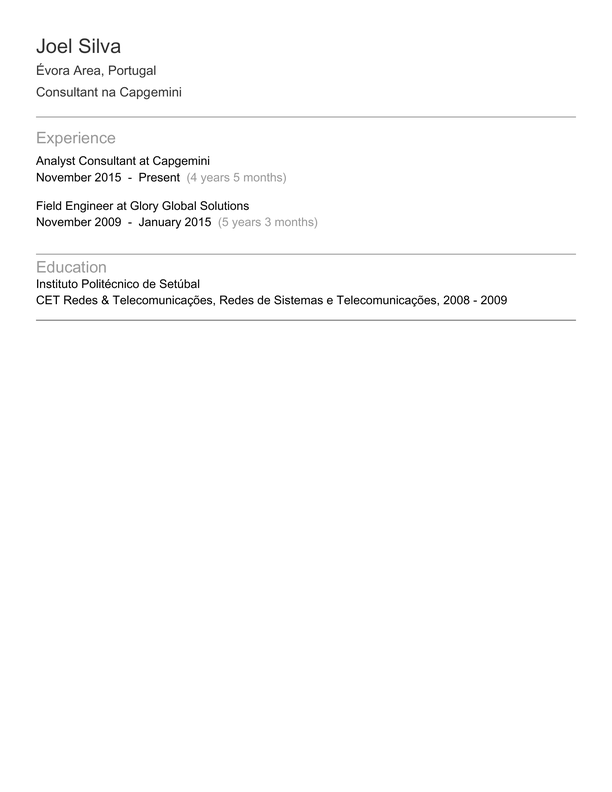

In [ ]:
example =  train_val_dataset["test"][7]
from PIL import Image, ImageDraw, ImageFont

image = Image.open(example['image'])
image = image.convert("RGB")
print(example.keys())
image

In [ ]:
encoded_inputs = processor(image, example['tokens'], boxes=example['bboxes'], word_labels=example['ner_tags'],
                           padding="max_length", truncation=True, return_tensors="pt")

In [ ]:
labels = encoded_inputs.pop('labels').squeeze().tolist()
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(device)

In [ ]:
# forward pass
outputs = model(**encoded_inputs)
print(outputs)

TokenClassifierOutput(loss=None, logits=tensor([[[-0.8640,  0.7458,  8.3957,  ...,  0.0219, -0.7587, -0.7754],
         [-0.8377,  6.2608,  0.3561,  ..., -2.0025, -0.2249, -1.0593],
         [-0.8640,  0.7458,  8.3957,  ...,  0.0219, -0.7587, -0.7754],
         ...,
         [-0.7828, -0.2887,  0.0591,  ..., -0.6547, -1.1436,  0.6942],
         [-0.5632, -0.5251,  0.0869,  ..., -0.7827, -0.8776, -0.0759],
         [-0.5632, -0.5251,  0.0869,  ..., -0.7827, -0.8776, -0.0760]]],
       device='cuda:0', grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)


In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         bbox[0],
         bbox[1],
         bbox[2],
         bbox[3],
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

true_predictions = [id2label[prediction] for prediction, label in zip(predictions, labels) if label != -100]
true_labels = [id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

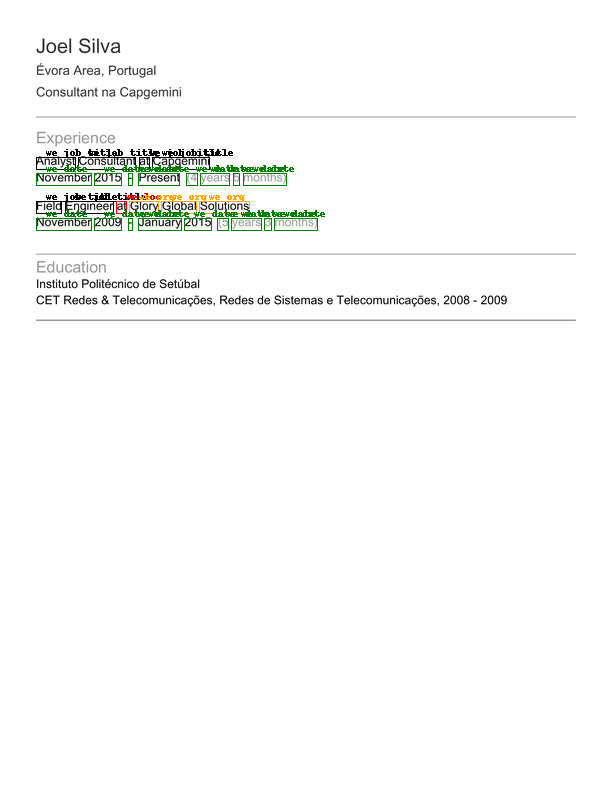

In [ ]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'o'
    return label

label2color = {'o': 'blue',
               'we_job_title': 'black', 
               'we_date': 'green',
               'we_org': 'orange',
               'we_loc': 'red',
               'technical_skills': 'purple',
               'languages': 'brown',
               'other': 'violet'
               }

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    #if predicted_label != 'o':
    draw.rectangle(box, outline=label2color[predicted_label])

    draw.text((box[0] + 10, box[1] - 10), text=f'{predicted_label}', fill=label2color[predicted_label], font=font)

image

# None

In [ ]:
writer.flush()

In [ ]:
writer.close()

In [ ]:
!kill 18406

In [ ]:
!zip -r /content/WE-modelXML-097.zip /content/modelXML/model-0.999

In [ ]:
from google.colab import files
files.download("/content/WE-modelXML-097.zip")

In [ ]:
!zip -r /content/runs.zip /content/runs/

  adding: content/runs/ (stored 0%)
  adding: content/runs/Mar05_12-32-33_9a05ce6e176b/ (stored 0%)
  adding: content/runs/Mar05_12-32-33_9a05ce6e176b/events.out.tfevents.1678019553.9a05ce6e176b.131.0 (deflated 69%)


In [ ]:
from google.colab import files
files.download("/content/runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>